<a href="https://colab.research.google.com/github/geekevgin/-Python/blob/main/HW_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [62]:
!pip install ucimlrepo

In [63]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
regensburg_pediatric_appendicitis = fetch_ucirepo(id=938)

# data (as pandas dataframes)
X = regensburg_pediatric_appendicitis.data.features
y = regensburg_pediatric_appendicitis.data.targets

# metadata
print(regensburg_pediatric_appendicitis.metadata)

# variable information
print(regensburg_pediatric_appendicitis.variables)


{'uci_id': 938, 'name': 'Regensburg Pediatric Appendicitis', 'repository_url': 'https://archive.ics.uci.edu/dataset/938/regensburg+pediatric+appendicitis', 'data_url': 'https://archive.ics.uci.edu/static/public/938/data.csv', 'abstract': 'This repository holds the data from a cohort of pediatric patients with suspected appendicitis admitted with abdominal pain to Children’s Hospital St. Hedwig in Regensburg, Germany, between 2016 and 2021. Each patient has (potentially multiple) ultrasound (US) images, aka views, tabular data comprising laboratory, physical examination, scoring results and ultrasonographic findings extracted manually by the experts, and three target variables, namely, diagnosis, management and severity.', 'area': 'Health and Medicine', 'tasks': ['Classification'], 'characteristics': ['Tabular', 'Image'], 'num_instances': 782, 'num_features': 53, 'feature_types': ['Real', 'Categorical', 'Integer'], 'demographics': ['Age', 'Sex'], 'target_col': ['Management', 'Severity',

Острый аппендицит - воспаление червеобразного отростки слепой кишки. Острый аппендицит одно из наиболее частых неотложных хирургических заболеваний органов брюшной полости.

Классификация:
-катаральный
-флегмонозный
-эмпиема
-гангренозный

Осложнения острого аппендицита:
- перфорация
- инфильтрат
- абцесс
- перитонит
- флегмона

Диагностика:
- Болезненность при пальпации в правой подвздошной области
- Защитное мышечнге напряжение(доскообразный живот)
- Симтом Щеткина
- УЗИ
- пальцевое ректальное исследование
- лейкоцитоз



В датасете есть много пустых значений касаемо осложнений, возможно в плане диагностики острого аппендицита при поступлении они не имеют значения, а больше подходчт для других двух признаков типа лечения и классификации осложнений.  
Этих данных так же мало по этой причине, что они соответствуют осложнениям и до этой стадии доходят редко, к счастью. Еще думаю это обусловлено тем, что в датасете дети, у которых более сильная иммуная система.

Поэтому у меня возник вопрос, что делать с этими пропусками в осложениях. Какую именно диагностическую ценность они имееют в плане классификации болен/не болен.

In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statistics import median
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score
from sklearn.ensemble import  RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier


EDA

In [65]:
X.head()

,Age,BMI,Sex,Height,Weight,Length_of_Stay,Alvarado_Score,Paedriatic_Appendicitis_Score,Appendix_on_US,Appendix_Diameter,...,Abscess_Location,Pathological_Lymph_Nodes,Lymph_Nodes_Location,Bowel_Wall_Thickening,Conglomerate_of_Bowel_Loops,Ileus,Coprostasis,Meteorism,Enteritis,Gynecological_Findings
0,12.68,16.9,female,148.0,37.0,3.0,4.0,3.0,yes,7.1,...,NaN,yes,reUB,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,14.10,31.9,male,147.0,69.5,2.0,5.0,4.0,no,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,yes,NaN,NaN
2,14.14,23.3,female,163.0,62.0,4.0,5.0,3.0,no,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,yes,yes,NaN
3,16.37,20.6,female,165.0,56.0,3.0,7.0,6.0,no,NaN,...,NaN,yes,reUB,NaN,NaN,NaN,NaN,NaN,yes,NaN
4,11.08,16.9,female,163.0,45.0,3.0,5.0,6.0,yes,7.0,...,NaN,yes,reUB,NaN,NaN,NaN,NaN,NaN,yes,NaN


In [66]:
X.isna().sum()

Age                                   1
BMI                                  27
Sex                                   2
Height                               26
Weight                                3
Length_of_Stay                        4
Alvarado_Score                       52
Paedriatic_Appendicitis_Score        52
Appendix_on_US                        5
Appendix_Diameter                   284
Migratory_Pain                        9
Lower_Right_Abd_Pain                  8
Contralateral_Rebound_Tenderness     15
Coughing_Pain                        16
Nausea                                8
Loss_of_Appetite                     10
Body_Temperature                      7
WBC_Count                             6
Neutrophil_Percentage               103
Segmented_Neutrophils               728
Neutrophilia                         50
RBC_Count                            18
Hemoglobin                           18
RDW                                  26
Thrombocyte_Count                    18


Видим, что много значений пропущено. Возможно удалить те значения, которых пропущено более 65% и посмотрим какие признаки остались

In [67]:
X_cols = X.columns
row, column = X.shape
drop_cols = []
for col in X_cols:
  if ((X[col].isna().sum()/len(X))*100) > 65:
    drop_cols.append(col)

print(len(drop_cols))
drop_cols

# Видно, что удалил осложнения, данные гистологии,симтомы нехарактерные для острой боли.

18


['Segmented_Neutrophils',
 'Appendix_Wall_Layers',
 'Target_Sign',
 'Appendicolith',
 'Perfusion',
 'Perforation',
 'Surrounding_Tissue_Reaction',
 'Appendicular_Abscess',
 'Abscess_Location',
 'Pathological_Lymph_Nodes',
 'Lymph_Nodes_Location',
 'Bowel_Wall_Thickening',
 'Conglomerate_of_Bowel_Loops',
 'Ileus',
 'Coprostasis',
 'Meteorism',
 'Enteritis',
 'Gynecological_Findings']

In [68]:
X = X.drop(drop_cols, axis = 1)
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 782 entries, 0 to 781
Data columns (total 35 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Age                               781 non-null    float64
 1   BMI                               755 non-null    float64
 2   Sex                               780 non-null    object 
 3   Height                            756 non-null    float64
 4   Weight                            779 non-null    float64
 5   Length_of_Stay                    778 non-null    float64
 6   Alvarado_Score                    730 non-null    float64
 7   Paedriatic_Appendicitis_Score     730 non-null    float64
 8   Appendix_on_US                    777 non-null    object 
 9   Appendix_Diameter                 498 non-null    float64
 10  Migratory_Pain                    773 non-null    object 
 11  Lower_Right_Abd_Pain              774 non-null    object 
 12  Contrala

In [69]:
unique_vals = y['Diagnosis']
print('Unique statuses:')
unique_vals

Unique statuses:


0         appendicitis
1      no appendicitis
2      no appendicitis
3      no appendicitis
4         appendicitis
            ...       
777       appendicitis
778       appendicitis
779       appendicitis
780       appendicitis
781       appendicitis
Name: Diagnosis, Length: 782, dtype: object

<Axes: >

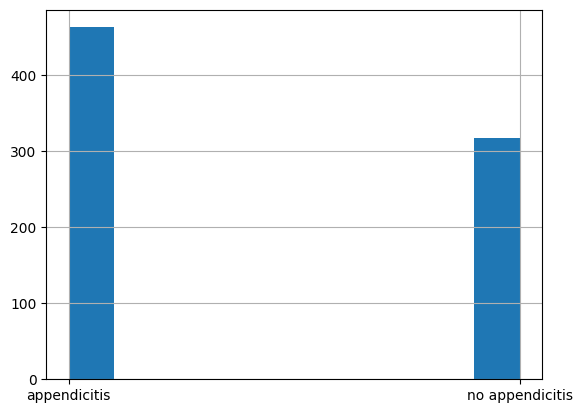

In [70]:
y['Diagnosis'].hist()

In [71]:
y.Diagnosis.value_counts() #значительного дисбаланса нет

Diagnosis
appendicitis       463
no appendicitis    317
Name: count, dtype: int64

In [72]:
# Получим список числовых столбцов
numeric_columns = X.select_dtypes(include=['number']).columns

# Создаем новый датасет, содержащий только числовые столбцы
new_X = X[numeric_columns]

# Выводим новый датасет
print(new_X)

       Age    BMI  Height  Weight  Length_of_Stay  Alvarado_Score  \
0    12.68  16.90   148.0    37.0             3.0             4.0   
1    14.10  31.90   147.0    69.5             2.0             5.0   
2    14.14  23.30   163.0    62.0             4.0             5.0   
3    16.37  20.60   165.0    56.0             3.0             7.0   
4    11.08  16.90   163.0    45.0             3.0             5.0   
..     ...    ...     ...     ...             ...             ...   
777  12.41  25.25   166.5    70.0             4.0             8.0   
778  17.09  20.43   158.0    51.0             6.0             5.0   
779  14.99  19.91   152.0    46.0             4.0             5.0   
780   7.20  14.30   129.3    23.9             5.0             9.0   
781  11.51  18.17   146.5    39.0             4.0             2.0   

     Paedriatic_Appendicitis_Score  Appendix_Diameter  Body_Temperature  \
0                              3.0                7.1              37.0   
1                    

In [73]:

# и теперь посмотрим на мультиколенеарность признаков
corr_matrix = new_X.corr()

# Проверяем корреляцию между каждой парой переменных
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > 0.5:
            print(f"Переменные {corr_matrix.columns[i]} и {corr_matrix.columns[j]} сильно коррелируют (r = {corr_matrix.iloc[i, j]:.3f}).")

Переменные Height и Age сильно коррелируют (r = 0.865).
Переменные Weight и Age сильно коррелируют (r = 0.766).
Переменные Weight и BMI сильно коррелируют (r = 0.859).
Переменные Weight и Height сильно коррелируют (r = 0.830).
Переменные Paedriatic_Appendicitis_Score и Alvarado_Score сильно коррелируют (r = 0.832).
Переменные WBC_Count и Alvarado_Score сильно коррелируют (r = 0.640).
Переменные Neutrophil_Percentage и Alvarado_Score сильно коррелируют (r = 0.701).
Переменные Neutrophil_Percentage и Paedriatic_Appendicitis_Score сильно коррелируют (r = 0.555).
Переменные Neutrophil_Percentage и WBC_Count сильно коррелируют (r = 0.663).
Переменные CRP и Length_of_Stay сильно коррелируют (r = 0.524).


Удалим следующие признаки:


*   Weight, тк есть равносильный индекс массы тела
*   Height, тк это дети и часто возраст соответствует определенному диапозогу роста


м следующие признаки:


*   Weight, тк есть равносильный индекс массы тела
*   Height, тк это дети и часто возраст соответствует определенному диапозогу роста


*   Paedriatic_Appendicitis_Score и Alvarado_Score. Это два признака, характерные для физикального осмотра.
*   WBC_Count и Alvarado_Score. Количество лейкоцитов и Alvarado_Score, тк аппендицит воспалительное заболевания, идет реакция иммунной системы. Поэтому удалим Alvarado_Score.
Тк и физикальный симптом и анализы могут быть показатльными в первые часы постановки диагноза.

*   Neutrophil_Percentage. Тоже реакция иммуной системы на воспаление. Коррелирует сразу с тремя признаками. Удалим его, оставим другие лабораторные показатели воспаления.
*   Length_of_Stay. Тк у нас задачи классификации, чтобы предположить диагноз в первые часы, то продолжительность койко-дней не важно. Хорошо использовать этот признак для других двух целевых.









In [74]:
# запрлним данныемнаиболее часто встречающимся значением
X = X.apply(lambda x:x.fillna(x.value_counts().index[0]))
np.where(X.isna())

(array([], dtype=int64), array([], dtype=int64))

In [75]:

for column in X:
    unique_vals = X[column].unique()
    print(f'Unique values from {column}:', sorted(unique_vals)[:10])

Unique values from Age: [0.0, 0.04, 0.53, 0.85, 1.73, 2.06, 2.13, 2.6, 2.8, 3.16]
Unique values from BMI: [7.83, 8.95, 10.9, 11.03, 11.34, 11.9, 12.15, 12.19, 12.25, 12.39]
Unique values from Sex: ['female', 'male']
Unique values from Height: [53.0, 83.5, 87.7, 90.0, 92.0, 94.6, 95.0, 96.0, 96.3, 97.0]
Unique values from Weight: [3.96, 12.0, 12.2, 12.5, 12.7, 13.0, 13.4, 14.0, 14.2, 14.5]
Unique values from Length_of_Stay: [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]
Unique values from Alvarado_Score: [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0]
Unique values from Paedriatic_Appendicitis_Score: [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0]
Unique values from Appendix_on_US: ['no', 'yes']
Unique values from Appendix_Diameter: [2.7, 2.9, 3.0, 3.2, 3.5, 3.7, 3.8, 4.0, 4.2, 4.3]
Unique values from Migratory_Pain: ['no', 'yes']
Unique values from Lower_Right_Abd_Pain: ['no', 'yes']
Unique values from Contralateral_Rebound_Tenderness: ['no', 'yes']
Unique values from Coughi

In [76]:
# Encode labels for classification models
label_encoder = LabelEncoder()
X = X.apply(label_encoder.fit_transform)
X.head()

,Age,BMI,Sex,Height,Weight,Length_of_Stay,Alvarado_Score,Paedriatic_Appendicitis_Score,Appendix_on_US,Appendix_Diameter,...,RBC_in_Urine,WBC_in_Urine,CRP,Dysuria,Stool,Peritonitis,Psoas_Sign,Ipsilateral_Rebound_Tenderness,US_Performed,Free_Fluids
0,369,185,0,104,116,2,4,3,1,35,...,0,3,0,0,3,2,1,0,1,0
1,428,499,1,101,231,1,5,4,0,44,...,3,3,4,1,3,2,1,0,1,0
2,430,418,0,142,213,3,5,3,0,44,...,3,3,4,0,0,2,1,0,1,0
3,530,340,0,147,191,2,7,6,0,44,...,3,3,0,1,3,2,1,0,1,0
4,274,185,0,142,151,2,5,6,1,34,...,3,3,0,0,0,2,1,0,1,0


In [77]:

for column in X:
    unique_vals = X[column].unique()
    print(f'Unique values from {column}:', sorted(unique_vals)[:10])

Unique values from Age: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Unique values from BMI: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Unique values from Sex: [0, 1]
Unique values from Height: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Unique values from Weight: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Unique values from Length_of_Stay: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Unique values from Alvarado_Score: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Unique values from Paedriatic_Appendicitis_Score: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Unique values from Appendix_on_US: [0, 1]
Unique values from Appendix_Diameter: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Unique values from Migratory_Pain: [0, 1]
Unique values from Lower_Right_Abd_Pain: [0, 1]
Unique values from Contralateral_Rebound_Tenderness: [0, 1]
Unique values from Coughing_Pain: [0, 1]
Unique values from Nausea: [0, 1]
Unique values from Loss_of_Appetite: [0, 1]
Unique values from Body_Temperature: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Unique values from WBC_Count: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Unique values from Ne

In [78]:

label_encoder = LabelEncoder()
y = y.apply(label_encoder.fit_transform)


In [79]:
len(X), len(y)




(782, 782)

In [80]:
y = y.drop(['Management', 'Severity'], axis= 1)

In [81]:
# Нормализуем данные, тк будем работать с Нс
scaler = StandardScaler()
X_scaler = scaler.fit_transform(X)
X_scaler

array([[ 0.46697236, -0.4024824 , -1.03647024, ..., -0.22599838,
         0.13984532, -0.81041944],
       [ 0.84154721,  1.88394987,  0.96481304, ..., -0.22599838,
         0.13984532, -0.81041944],
       [ 0.85424467,  1.29413772, -1.03647024, ..., -0.22599838,
         0.13984532, -0.81041944],
       ...,
       [ 1.10184499,  0.52956642, -1.03647024, ..., -0.22599838,
         0.13984532,  1.23392895],
       [-1.30432227, -1.34181286,  0.96481304, ..., -0.22599838,
         0.13984532,  1.23392895],
       [ 0.05430515, -0.0311192 ,  0.96481304, ..., -0.22599838,
         0.13984532, -0.81041944]])

BASE LINE

In [82]:
X_train, X_test, y_train, y_test = train_test_split(X_scaler, y, test_size=0.2, random_state=42)

DecisionTreeClassifier

In [83]:
model_clf_tree = DecisionTreeClassifier(criterion="gini",
                                      random_state=100, max_depth=5, min_samples_leaf=5)


model_clf_tree = model_clf_tree.fit(X_train, y_train)
y_pred_clf_tree = model_clf_tree.predict(X_test)
accuracy_clf_tree = accuracy_score(y_test, y_pred_clf_tree)
f1_clf_tree = f1_score(y_test, y_pred_clf_tree)
print(accuracy_clf_tree)
print(f1_clf_tree)

0.9363057324840764
0.9166666666666667


Random Forest

In [84]:
model_RF = RandomForestClassifier(random_state=100, max_depth=5, n_estimators=100)
model_RF = model_RF.fit(X_train, y_train)
y_pred_RF = model_RF.predict(X_test)
accuracy_RF = accuracy_score(y_test, y_pred_RF)
f1_RF = f1_score(y_test, y_pred_RF)

print(accuracy_RF)
print(f1_RF)

<ipython-input-84-fc88b9518f35>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model_RF = model_RF.fit(X_train, y_train)


0.8471337579617835
0.7999999999999999


In [85]:
model_mlp_clf = MLPClassifier(random_state=1, max_iter=300).fit(X_train, y_train)
y_pred_mlp_clf = model_mlp_clf.predict(X_test)
accuracy_mlp = accuracy_score(y_test, y_pred_mlp_clf)
precision_score_mlp = precision_score(y_test, y_pred_mlp_clf, average='micro', labels=None, sample_weight=None)

print(accuracy_mlp)
print(precision_score_mlp)

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.8343949044585988
0.8343949044585988


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


HC

In [86]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import optimizers
from keras.callbacks import History
from keras.callbacks import EarlyStopping
from keras.regularizers import l2

In [87]:
# создаем модель с 32 входными нейронными слоями
model32 = Sequential()
model32.add(Dense(32, input_dim=X_train.shape[1], activation='relu'))
model32.add(Dense(16, activation='relu'))
model32.add(Dense(1, activation='sigmoid'))

model32.compile(optimizer=optimizers.Adam(learning_rate=0.001),
                loss='binary_crossentropy',
                metrics=['accuracy'])

In [88]:
# 64 dense layer

model64 = Sequential()
model64.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
model64.add(Dense(32, activation='relu'))
model64.add(Dense(1, activation='sigmoid'))

model64.compile(optimizer=optimizers.Adam(learning_rate=0.001),
                loss='binary_crossentropy',
                metrics=['accuracy'])

In [89]:
# L2 regularization
model_l2 = Sequential()
model_l2.add(Dense(32, input_dim=X_train.shape[1], activation='relu', kernel_regularizer=l2(0.001)))
model_l2.add(Dense(16, activation='relu', kernel_regularizer=l2(0.001)))
model_l2.add(Dense(1, activation='sigmoid'))

model_l2.compile(optimizer=optimizers.Adam(learning_rate=0.001),
                 loss='binary_crossentropy',
                 metrics=['accuracy'])

In [90]:
# dropout
model_dropout = Sequential()
model_dropout.add(Dense(32, input_dim=X_train.shape[1], activation='relu'))
model_dropout.add(Dropout(0.5))
model_dropout.add(Dense(16, activation='relu'))
model_dropout.add(Dropout(0.5))
model_dropout.add(Dense(1, activation='sigmoid'))

model_dropout.compile(optimizer=optimizers.Adam(learning_rate=0.001),
                      loss='binary_crossentropy',
                      metrics=['accuracy'])

Epoch 1/50
79/79 [==============================] - 3s 17ms/step - loss: 0.5490 - accuracy: 0.7264 - val_loss: 0.4776 - val_accuracy: 0.7389
Epoch 2/50
79/79 [==============================] - 1s 9ms/step - loss: 0.3815 - accuracy: 0.8432 - val_loss: 0.3975 - val_accuracy: 0.8153
Epoch 3/50
79/79 [==============================] - 1s 9ms/step - loss: 0.2891 - accuracy: 0.8832 - val_loss: 0.3539 - val_accuracy: 0.8153
Epoch 4/50
79/79 [==============================] - 1s 8ms/step - loss: 0.2358 - accuracy: 0.9152 - val_loss: 0.3295 - val_accuracy: 0.8344
Epoch 5/50
79/79 [==============================] - 1s 6ms/step - loss: 0.1939 - accuracy: 0.9328 - val_loss: 0.3246 - val_accuracy: 0.8153
Epoch 6/50
79/79 [==============================] - 1s 7ms/step - loss: 0.1661 - accuracy: 0.9520 - val_loss: 0.3244 - val_accuracy: 0.8280
Epoch 7/50
79/79 [==============================] - 1s 9ms/step - loss: 0.1415 - accuracy: 0.9504 - val_loss: 0.3346 - val_accuracy: 0.8280


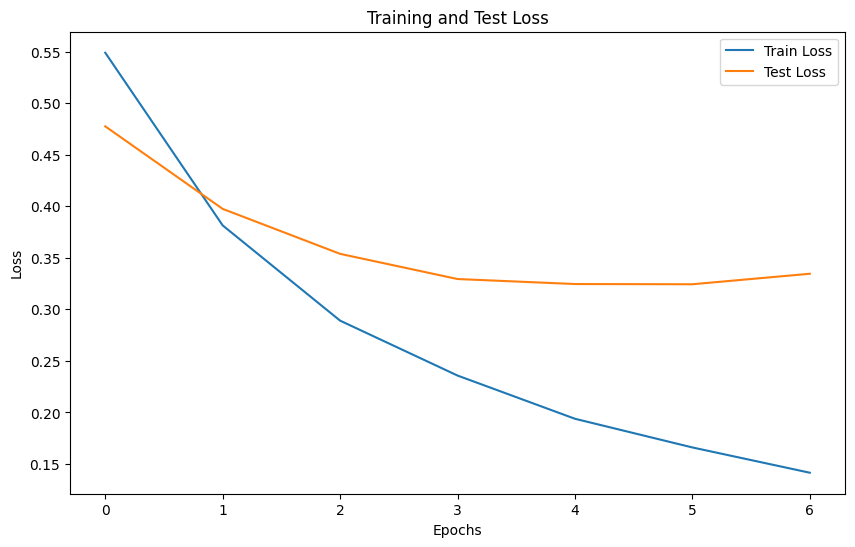

Epoch 1/50
79/79 [==============================] - 3s 11ms/step - loss: 0.6892 - accuracy: 0.5680 - val_loss: 0.6200 - val_accuracy: 0.6624
Epoch 2/50
79/79 [==============================] - 1s 7ms/step - loss: 0.5183 - accuracy: 0.7456 - val_loss: 0.5231 - val_accuracy: 0.7452
Epoch 3/50
79/79 [==============================] - 1s 10ms/step - loss: 0.4220 - accuracy: 0.8000 - val_loss: 0.4647 - val_accuracy: 0.7643
Epoch 4/50
79/79 [==============================] - 1s 12ms/step - loss: 0.3464 - accuracy: 0.8544 - val_loss: 0.4245 - val_accuracy: 0.7898
Epoch 5/50
79/79 [==============================] - 1s 8ms/step - loss: 0.2870 - accuracy: 0.8848 - val_loss: 0.3924 - val_accuracy: 0.8153
Epoch 6/50
79/79 [==============================] - 1s 9ms/step - loss: 0.2389 - accuracy: 0.9088 - val_loss: 0.3595 - val_accuracy: 0.8408
Epoch 7/50
79/79 [==============================] - 1s 12ms/step - loss: 0.2086 - accuracy: 0.9216 - val_loss: 0.3583 - val_accuracy: 0.8471
Epoch 8/50
79/79

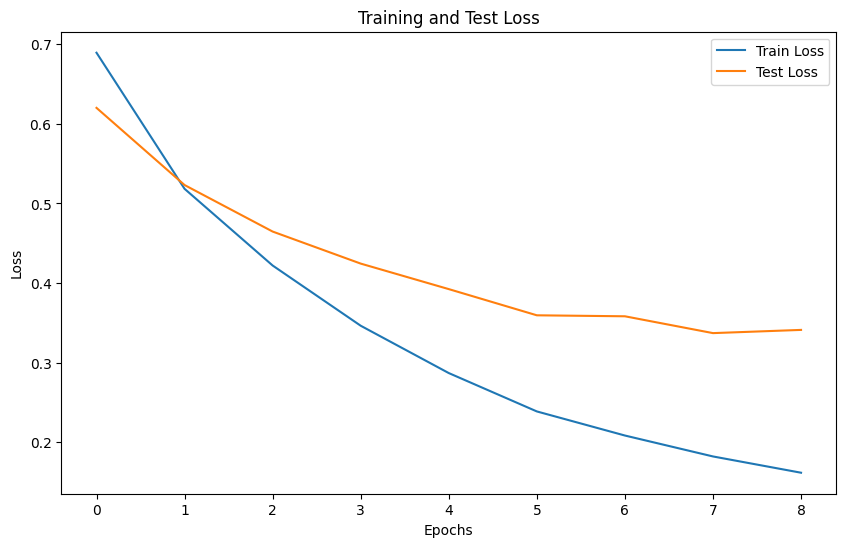

Epoch 1/50
79/79 [==============================] - 3s 12ms/step - loss: 0.6819 - accuracy: 0.6768 - val_loss: 0.6523 - val_accuracy: 0.6943
Epoch 2/50
79/79 [==============================] - 1s 7ms/step - loss: 0.5535 - accuracy: 0.7760 - val_loss: 0.5757 - val_accuracy: 0.7325
Epoch 3/50
79/79 [==============================] - 1s 8ms/step - loss: 0.4528 - accuracy: 0.8336 - val_loss: 0.5190 - val_accuracy: 0.7707
Epoch 4/50
79/79 [==============================] - 1s 8ms/step - loss: 0.3762 - accuracy: 0.8656 - val_loss: 0.4678 - val_accuracy: 0.7898
Epoch 5/50
79/79 [==============================] - 1s 7ms/step - loss: 0.3209 - accuracy: 0.8912 - val_loss: 0.4332 - val_accuracy: 0.8153
Epoch 6/50
79/79 [==============================] - 1s 8ms/step - loss: 0.2812 - accuracy: 0.9136 - val_loss: 0.4064 - val_accuracy: 0.8217
Epoch 7/50
79/79 [==============================] - 1s 9ms/step - loss: 0.2577 - accuracy: 0.9184 - val_loss: 0.3924 - val_accuracy: 0.8280
Epoch 8/50
79/79 [=

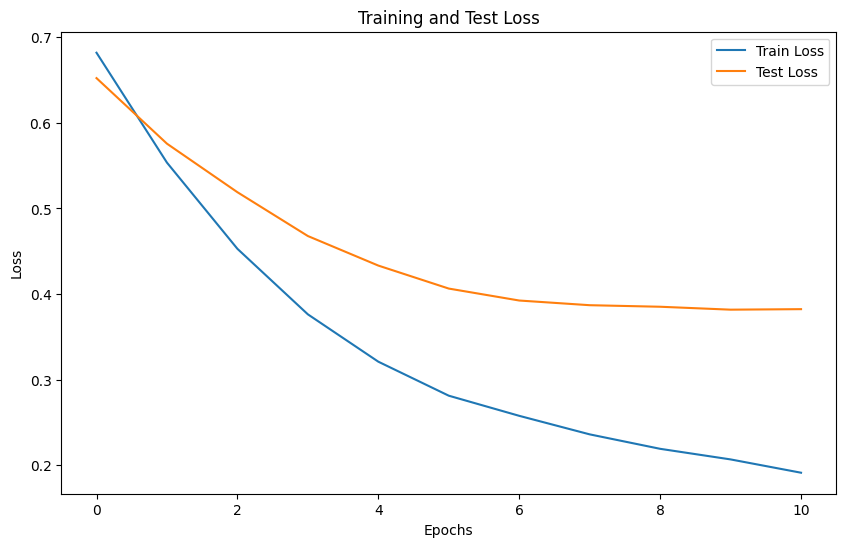

Epoch 1/50
79/79 [==============================] - 4s 14ms/step - loss: 0.9186 - accuracy: 0.5088 - val_loss: 0.6457 - val_accuracy: 0.6051
Epoch 2/50
79/79 [==============================] - 0s 4ms/step - loss: 0.7443 - accuracy: 0.5888 - val_loss: 0.5962 - val_accuracy: 0.6752
Epoch 3/50
79/79 [==============================] - 0s 4ms/step - loss: 0.7042 - accuracy: 0.5856 - val_loss: 0.5685 - val_accuracy: 0.6497
Epoch 4/50
79/79 [==============================] - 0s 4ms/step - loss: 0.6507 - accuracy: 0.6128 - val_loss: 0.5458 - val_accuracy: 0.6943
Epoch 5/50
79/79 [==============================] - 0s 5ms/step - loss: 0.5764 - accuracy: 0.6864 - val_loss: 0.5275 - val_accuracy: 0.7070
Epoch 6/50
79/79 [==============================] - 0s 5ms/step - loss: 0.6077 - accuracy: 0.6704 - val_loss: 0.5135 - val_accuracy: 0.7134
Epoch 7/50
79/79 [==============================] - 0s 5ms/step - loss: 0.5549 - accuracy: 0.6944 - val_loss: 0.4998 - val_accuracy: 0.7452
Epoch 8/50
79/79 [=

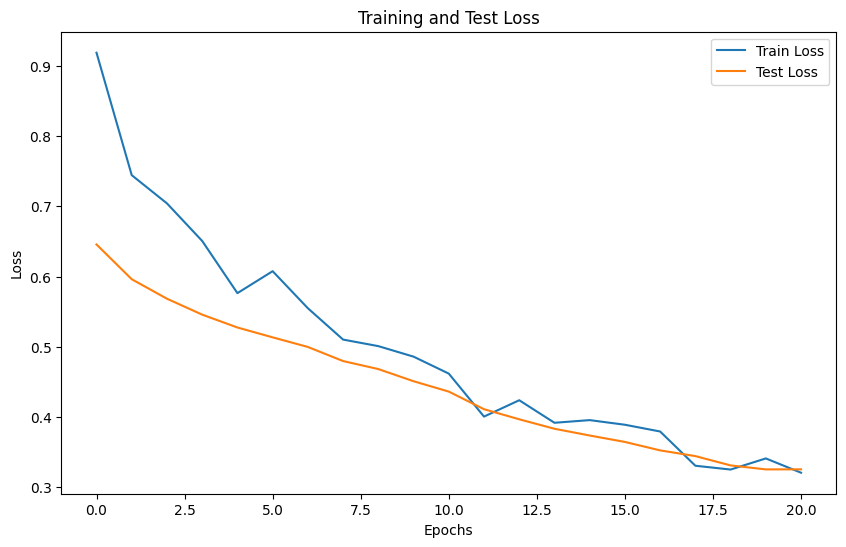

In [91]:
# Fit
for model, name in [
    (model64, 'dense 64 model'),
    (model32, 'dense 64 model'),
    (model_l2, 'l2 regularization model'),
    (model_dropout, 'dropout model'),
]:
    early_stopping = EarlyStopping(monitor='val_loss', patience=1, restore_best_weights=True)

    history = History()
    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=50,
        batch_size=8,
        callbacks=[history, early_stopping],
        verbose=1
    )

    plt.figure(figsize=(10,6))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Test Loss')
    plt.legend()
    plt.show()

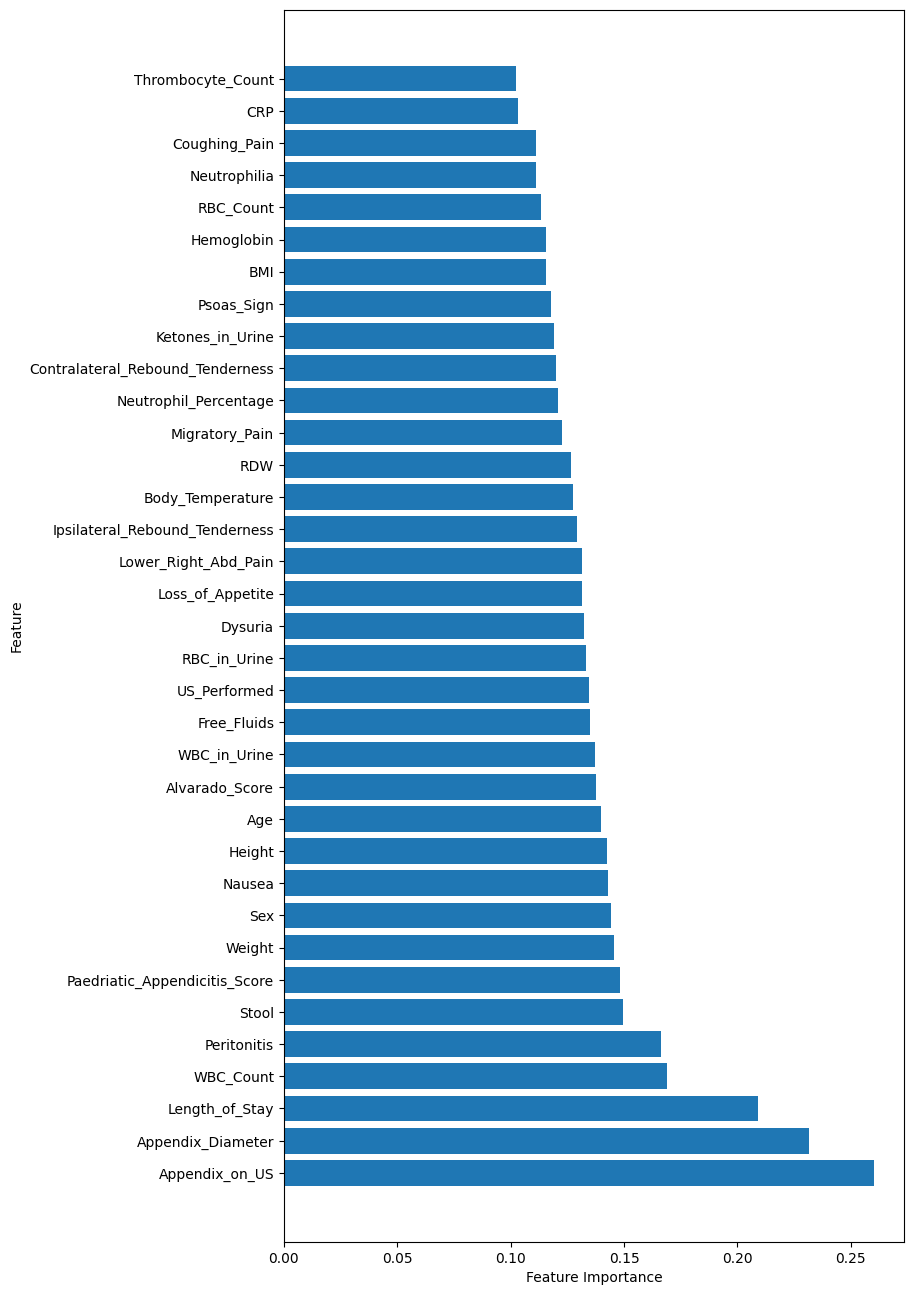

In [93]:
# Visualise weights
weights = model_dropout.layers[0].get_weights()[0]
feature_importance = np.mean(np.abs(weights), axis=1)

feature_importance_df = pd.DataFrame({'feature': X.columns, 'importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

plt.figure(figsize=(8,16))
plt.barh(feature_importance_df['feature'], feature_importance_df['importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')

plt.show()

Наибольшую точность среди классификатор получила модель дерево решений 0.9166666666666667. RF, MPL получили почти одинаковые значения 83. Возможно дерево переобучается.

НС. Наибольшая точность у model32 - скор 95
модель с dropout - скор 84

можно судить, что наши модели более чем 83% случаев предсказвают верный диагноз

Последние слово за хирургом.